 # Chicago Health Equity Index: Data Engineering : Final Model
   * Data is collected at the census tract level where possible. Various data features can be grouped into the following catagories: **Economic, Transportation, Education, and Safety**
   * Response feature is csv extract from the CDC: https://www.cdc.gov/nchs/data-visualization/life-expectancy/index.html# 
   * Model features are called via US Census API and SOCRATA API via City of Chicago Data Portal

   * Census data collected from the API of the ACS 5 year from 2015 at the data profile level: Data Dictionary can be found here: https://api.census.gov/data/2015/acs/acs5/profile/variables.html

   * Additional Census Data can be added from the detailed tables here: https://www.census.gov/data/developers/data-sets/acs-5year.html
        * **Detailed Tables** contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population counts. There are over 20,000 variables in this dataset.
        * **Subject Tables** provide an overview of the estimates available in a particular topic.  The data are presented as population counts and percentages.  There are over 18,000 variables in this dataset. 
        * **Data Profiles** contain broad social, economic, housing, and demographic information. The data are presented as population counts and percentages. There are over 1,000 variables in this dataset.
        * **Comparison Profiles** are similar to Data Profiles but also include comparisons with past-year data.  The current year data are compared with prior 5-Year data and include statistical significance testing.  There are over 1,000 variables in this dataset.

## Import Libraries, Functions, and Flat Files

In [2]:
#Import Libraries
from secrets import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from census import Census
from us import states
from datetime import datetime
from sodapy import Socrata

In [3]:
#Import Flat Files
life_expectancy = pd.read_csv('LifeExp.csv')
chicago_tracts=pd.read_csv('Chicago_Tracts.csv')

In [4]:
#Define API Call Functions


def get_census_dp(variables,year=2015):
    c=Census(census_key, year=year)
    # Get the ACS data
    variable_codes=list(variables.values())
    variable_codes.append('NAME')
    data = c.acs5dp.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    # Rename columns based on the variable_map keys
    reverse_map = {v: k for k, v in variables.items()}  # Reverse the mapping for renaming
    census_df.rename(columns=reverse_map, inplace=True)

    return census_df

def get_census_dt(variable_codes):
    # Get the ACS data
    variable_codes.append('NAME')
    data = c.acs5.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    return census_df

In [5]:
# Example usage
variables= {
    'Insured_Pe': 'DP03_0096PE',
    'NonInsured_Pe': 'DP03_0099PE'
}

df_test=get_census_dp(variables)
df_test.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,83.2,16.8,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,86.5,13.5,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,94.2,5.8,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Response Variables: Length of Life and Quality of Life

In [6]:
life_expectancy = life_expectancy[(life_expectancy['State'] == 'Illinois') & (life_expectancy['County'].str.contains('Cook'))]

In [7]:
life_expectancy['Tract'] = life_expectancy['Census Tract Number']
life_expectancy['Tract'] = life_expectancy['Tract']*100
life_expectancy['tract'] = life_expectancy['Tract'].astype(int).astype(str)
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract
21114,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100
21115,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201
21116,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202
21117,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300
21118,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400


### Filter Response to Only Chicago Tracts

In [8]:
chicago_tracts['tract']=chicago_tracts['TRACTCE10']
chicago_tracts['tract']=chicago_tracts['tract'].astype(str)

In [9]:
life_expectancy = pd.merge(life_expectancy,chicago_tracts, on='tract', how='inner')
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
0,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100,MULTIPOLYGON (((-87.66368000002299 42.01939800...,17,31,10100,17031010100,101.00,Census Tract 101,1,ROGERS PARK,Far North Side
1,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201,MULTIPOLYGON (((-87.6800950000417 42.012537999...,17,31,10201,17031010201,102.01,Census Tract 102.01,1,ROGERS PARK,Far North Side
2,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202,MULTIPOLYGON (((-87.67335799998422 42.01937400...,17,31,10202,17031010202,102.02,Census Tract 102.02,1,ROGERS PARK,Far North Side
3,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300,MULTIPOLYGON (((-87.66505999995483 42.01280100...,17,31,10300,17031010300,103.00,Census Tract 103,1,ROGERS PARK,Far North Side
4,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400,MULTIPOLYGON (((-87.65080299995667 41.99848500...,17,31,10400,17031010400,104.00,Census Tract 104,1,ROGERS PARK,Far North Side


### Test Join on Tract Level

In [10]:
merge_df=pd.merge(df_test, life_expectancy, on='tract', how='inner')
merge_df.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract,State,County,Census Tract Number,Life Expectancy,...,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400,Illinois,"Cook County, IL",2714.0,68.6,...,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,West Side
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100,Illinois,"Cook County, IL",2801.0,NaN,...,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE,West Side
2,68.6,31.4,"Census Tract 3103, Cook County, Illinois",17,031,310300,Illinois,"Cook County, IL",3103.0,79.1,...,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE,West Side
3,78.1,21.9,"Census Tract 2002, Cook County, Illinois",17,031,200200,Illinois,"Cook County, IL",2002.0,78.5,...,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA,Northwest Side
4,75.8,24.2,"Census Tract 2214, Cook County, Illinois",17,031,221400,Illinois,"Cook County, IL",2214.0,80.9,...,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE,North Side


## Feature List

In [11]:
features = {
    'Labor Force': 'DP03_0002E',  # Population 16+ in labor force
    'Unemployed': 'DP03_0005PE',  # %Unemployed population 16+ in civilian labor force
    'Employed':'DP03_0004PE', # %Employed population labor force
    'Family Poverty': 'DP03_0119PE',  # % Families below poverty level
    'No HS':'DP02_0059PE',#No High school
    'Some HS':'DP02_0060PE',#Some High School
    'HS Graduates': 'DP02_0061PE',  # % Population 25+ with high school diploma
    'Bachelors Degree': 'DP02_0064PE',  # % Population 25+ with bachelor's degree
    'Grad/Prof Degree': 'DP02_0065PE',  # % Population 25+ with graduate or professional degree
    'Private Health Ins': 'DP03_0097PE',  # % Population with private health insurance
    'Public Health Ins': 'DP03_0098PE',  # % Population with public health insurance
    'No Health Ins': 'DP03_0099PE',  # % Population without health insurance
    'No Vehicles': 'DP04_0058PE',  # % % Households with no vehicles
    'One Vehicle': 'DP04_0059PE',  # % Households with 1 vehicle
    'Two Vehicles': 'DP04_0060PE',  # % Households with 2 vehicles
    'Three+ Vehicles': 'DP04_0061PE',  # % Households with 3+ vehicles
    'Drive Alone': 'DP03_0019PE',  # % Commute by driving alone
    'Carpooled': 'DP03_0020PE',  #  % Commute by carpooling
    'Walked': 'DP03_0022PE', #% commute by walking
    'Other means': 'DP03_0023PE', # % commute by other means
    'WFH': 'DP03_0024PE', # % WFH
    'Public Transit': 'DP03_0021PE',  # % Commute by public transportation
    'Total Population': 'DP02_0122E',  # Total population by ancestry
    'Male':'DP05_0002PE', #% of Population Male
    'Female':'DP05_0003PE' #% of Population Female 
}


## Call API Data

In [12]:
features_df=get_census_dp(features)
features_df.head()

,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,...,Other means,WFH,Public Transit,Total Population,Male,Female,NAME,state,county,tract
0,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,...,7.8,11.2,41.2,1185.0,51.9,48.1,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,...,6.1,7.3,14.1,6811.0,49.3,50.7,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,2447.0,11.3,55.5,13.3,7.6,7.4,35.4,12.1,9.6,57.2,...,1.4,0.3,8.8,4643.0,49.7,50.3,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,812.0,12.6,48.6,27.4,5.1,11.5,35.2,8.8,2.7,39.2,...,0.0,7.1,20.8,1858.0,43.1,56.9,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,3100.0,7.3,65.1,4.5,3.9,4.0,26.8,19.9,12.1,83.1,...,0.8,1.9,10.0,5369.0,46.8,53.2,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Joined Model

In [13]:
#merge
model=pd.merge(features_df, life_expectancy, on='tract', how='inner')
model.head()

,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,...,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
0,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,...,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,West Side
1,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,...,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE,West Side
2,1126.0,11.1,66.0,14.2,14.4,7.9,15.6,26.3,11.7,49.5,...,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE,West Side
3,2440.0,7.4,57.7,26.9,22.8,14.5,34.6,6.8,2.6,32.8,...,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA,Northwest Side
4,2048.0,2.9,76.9,12.7,4.5,8.8,22.6,29.6,14.7,63.7,...,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE,North Side


In [14]:
model.describe()

,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,...,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,Tract,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,commarea
count,800.000000,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,...,800.000000,701.000000,701.000000,800.000000,800.0,800.0,800.000000,8.000000e+02,800.000000,800.000000
mean,1819.951250,-2.499991e+06,-2.499944e+06,-2.499980e+06,-2.499991e+06,-2.499991e+06,-2.499976e+06,-2.499980e+06,-2.499987e+06,-2.499947e+06,...,4058.249075,76.621826,2.158328,405824.907500,17.0,31.0,405824.905000,1.703141e+10,4058.249050,34.946250
std,1108.278481,4.077370e+07,4.077371e+07,4.077370e+07,4.077370e+07,4.077370e+07,4.077370e+07,4.077370e+07,4.077370e+07,4.077371e+07,...,2778.272753,4.666589,0.704843,277827.275273,0.0,0.0,277827.278655,2.778273e+05,2778.272787,22.761832
min,0.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,...,101.000000,59.900000,0.874700,10100.000000,17.0,31.0,10100.000000,1.703101e+10,101.000000,1.000000
25%,991.500000,4.800000e+00,4.520000e+01,7.100000e+00,2.400000e+00,4.175000e+00,1.527500e+01,7.800000e+00,3.475000e+00,3.357500e+01,...,1609.750000,73.300000,1.618200,160975.000000,17.0,31.0,160975.000000,1.703116e+10,1609.750000,16.000000
50%,1666.000000,7.600000e+00,5.685000e+01,1.750000e+01,5.900000e+00,8.600000e+00,2.610000e+01,1.490000e+01,8.400000e+00,5.060000e+01,...,3558.500000,77.200000,2.023500,355850.000000,17.0,31.0,355850.000000,1.703136e+10,3558.500000,29.000000
75%,2457.250000,1.150000e+01,6.520000e+01,2.950000e+01,1.250000e+01,1.370000e+01,3.302500e+01,2.845000e+01,2.022500e+01,7.275000e+01,...,6704.250000,80.300000,2.581000,670425.000000,17.0,31.0,670425.000000,1.703167e+10,6704.250000,56.000000
max,12810.000000,5.900000e+01,9.180000e+01,7.230000e+01,4.460000e+01,3.910000e+01,5.630000e+01,6.650000e+01,7.490000e+01,9.690000e+01,...,9801.000000,90.000000,3.947000,980100.000000,17.0,31.0,980100.000000,1.703198e+10,9801.000000,77.000000


### Clean up empty and 0 values

In [15]:
#for each value in model, count empty values
model.isnull().sum()

Labor Force                        0
Unemployed                         0
Employed                           0
Family Poverty                     0
No HS                              0
Some HS                            0
HS Graduates                       0
Bachelors Degree                   0
Grad/Prof Degree                   0
Private Health Ins                 0
Public Health Ins                  0
No Health Ins                      0
No Vehicles                        0
One Vehicle                        0
Two Vehicles                       0
Three+ Vehicles                    0
Drive Alone                        0
Carpooled                          0
Walked                             0
Other means                        0
WFH                                0
Public Transit                     0
Total Population                   0
Male                               0
Female                             0
NAME                               0
state                              0
c

In [16]:
model.dtypes

Labor Force                       float64
Unemployed                        float64
Employed                          float64
Family Poverty                    float64
No HS                             float64
Some HS                           float64
HS Graduates                      float64
Bachelors Degree                  float64
Grad/Prof Degree                  float64
Private Health Ins                float64
Public Health Ins                 float64
No Health Ins                     float64
No Vehicles                       float64
One Vehicle                       float64
Two Vehicles                      float64
Three+ Vehicles                   float64
Drive Alone                       float64
Carpooled                         float64
Walked                            float64
Other means                       float64
WFH                               float64
Public Transit                    float64
Total Population                  float64
Male                              

In [17]:
int_columns = model.select_dtypes(include='float64').columns
count_less_than_zero = model[int_columns].lt(0).sum()
count_less_than_zero


Labor Force                       0
Unemployed                        3
Employed                          3
Family Poverty                    3
No HS                             3
Some HS                           3
HS Graduates                      3
Bachelors Degree                  3
Grad/Prof Degree                  3
Private Health Ins                3
Public Health Ins                 3
No Health Ins                     3
No Vehicles                       3
One Vehicle                       3
Two Vehicles                      3
Three+ Vehicles                   3
Drive Alone                       3
Carpooled                         3
Walked                            3
Other means                       3
WFH                               3
Public Transit                    3
Total Population                  0
Male                              3
Female                            3
Census Tract Number               0
Life Expectancy                   0
Life Expectancy Standard Err

In [18]:
#show all columns in pd df
pd.set_option('display.max_columns', None)

#see records where float64 is less than 0
model[model[int_columns].lt(0).any(axis=1)]


,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,NAME,state,county,tract,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,area
363,0.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0.0,-666666666.0,-666666666.0,"Census Tract 9801, Cook County, Illinois",17,031,980100,Illinois,"Cook County, IL",9801.0,NaN,NaN,NaN,980100.0,MULTIPOLYGON (((-87.73789600001243 41.78578500...,17,31,980100,17031980100,9801.0,Census Tract 9801,56,GARFIELD RIDGE,Southwest Side
364,0.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0.0,-666666666.0,-666666666.0,"Census Tract 9800, Cook County, Illinois",17,031,980000,Illinois,"Cook County, IL",9800.0,NaN,NaN,NaN,980000.0,MULTIPOLYGON (((-87.92062799997296 42.00453199...,17,31,980000,17031980000,9800.0,Census Tract 9800,76,OHARE,Far North Side
721,0.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,0.0,-666666666.0,-666666666.0,"Census Tract 3817, Cook County, Illinois",17,031,381700,Illinois,"Cook County, IL",3817.0,NaN,NaN,NaN,381700.0,MULTIPOLYGON (((-87.62798399996935 41.80191199...,17,31,381700,17031381700,3817.0,Census Tract 3817,38,GRAND BOULEVARD,South Side


In [19]:
#Drop records where float64 is less than  0 in employed column
model = model[model['Employed']>=0]

In [20]:
int_columns = model.select_dtypes(include='float64').columns
count_less_than_zero = model[int_columns].lt(0).sum()
count_less_than_zero

Labor Force                       0
Unemployed                        0
Employed                          0
Family Poverty                    0
No HS                             0
Some HS                           0
HS Graduates                      0
Bachelors Degree                  0
Grad/Prof Degree                  0
Private Health Ins                0
Public Health Ins                 0
No Health Ins                     0
No Vehicles                       0
One Vehicle                       0
Two Vehicles                      0
Three+ Vehicles                   0
Drive Alone                       0
Carpooled                         0
Walked                            0
Other means                       0
WFH                               0
Public Transit                    0
Total Population                  0
Male                              0
Female                            0
Census Tract Number               0
Life Expectancy                   0
Life Expectancy Standard Err

In [21]:
model.describe()

,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,Tract,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,commarea
count,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,797.000000,701.000000,701.000000,797.000000,797.0,797.0,797.000000,7.970000e+02,797.000000,797.000000
mean,1826.801757,8.813174,56.407403,19.795483,9.026223,9.350439,24.348683,19.671016,13.205019,53.427980,36.269009,16.559598,26.880803,43.915056,22.476035,6.725972,50.541029,8.567378,5.611167,2.888206,4.136763,28.261104,3435.249686,48.116688,51.883312,4044.142108,76.621826,2.158328,404414.210790,17.0,31.0,404414.208281,1.703140e+10,4044.142083,34.864492
std,1104.708175,5.548531,14.685359,14.856287,9.222673,6.413608,11.858645,14.413846,12.613016,22.719282,17.319026,8.436024,14.727346,8.737200,10.878483,5.754209,14.985352,5.809504,7.968270,3.073033,3.169387,12.607622,1798.503447,4.773986,4.773986,2768.532141,4.666589,0.704843,276853.214064,0.0,0.0,276853.217459,2.768532e+05,2768.532175,22.745571
min,117.000000,0.000000,5.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.800000,3.300000,0.400000,1.100000,18.800000,0.000000,0.000000,5.700000,0.000000,0.000000,0.000000,0.000000,0.000000,252.000000,26.000000,12.000000,101.000000,59.900000,0.874700,10100.000000,17.0,31.0,10100.000000,1.703101e+10,101.000000,1.000000
25%,998.000000,4.900000,45.400000,7.200000,2.400000,4.200000,15.400000,7.900000,3.500000,33.900000,22.600000,10.000000,15.000000,38.200000,14.200000,2.100000,40.200000,4.300000,1.400000,0.400000,1.600000,18.400000,1996.000000,45.200000,48.800000,1609.000000,73.300000,1.618200,160900.000000,17.0,31.0,160900.000000,1.703116e+10,1609.000000,16.000000
50%,1676.000000,7.600000,56.900000,17.600000,5.900000,8.600000,26.100000,14.900000,8.400000,50.600000,36.900000,16.300000,24.600000,43.800000,21.100000,5.200000,50.700000,7.500000,3.300000,2.000000,3.700000,26.800000,3087.000000,48.400000,51.600000,3514.000000,77.200000,2.023500,351400.000000,17.0,31.0,351400.000000,1.703135e+10,3514.000000,29.000000
75%,2458.000000,11.500000,65.200000,29.500000,12.500000,13.700000,33.100000,28.600000,20.300000,72.900000,49.200000,22.200000,37.200000,49.900000,29.800000,9.700000,61.100000,11.600000,6.300000,4.400000,5.900000,37.300000,4577.000000,51.200000,54.800000,6703.000000,80.300000,2.581000,670300.000000,17.0,31.0,670300.000000,1.703167e+10,6703.000000,56.000000
max,12810.000000,59.000000,91.800000,72.300000,44.600000,39.100000,56.300000,66.500000,74.900000,96.900000,78.400000,45.000000,74.700000,75.500000,58.500000,30.700000,100.000000,39.400000,59.600000,23.100000,18.400000,71.000000,17935.000000,88.000000,74.000000,8439.000000,90.000000,3.947000,843900.000000,17.0,31.0,843900.000000,1.703184e+10,8439.000000,77.000000


In [22]:
#descibe life expectancy in model
model['Life Expectancy'].describe()
#count nan
model['Life Expectancy'].isnull().sum()


96

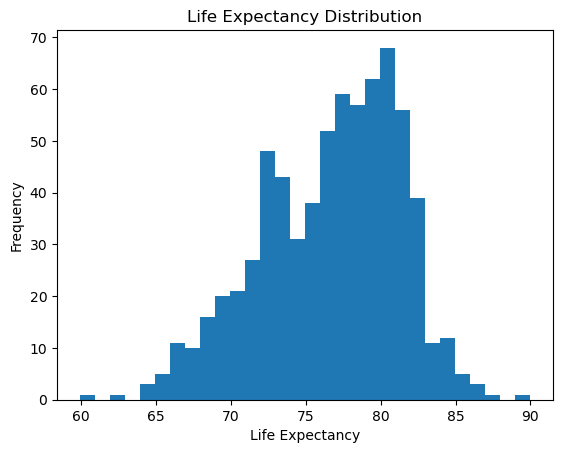

In [23]:
#create a histogram of life expectancy in model
plt.hist(model['Life Expectancy'], bins=30)
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.title('Life Expectancy Distribution')
plt.show()

In [35]:
#Imputing life expectency
import numpy as np
from sklearn.impute import KNNImputer

imputer=KNNImputer(n_neighbors=10,weights='distance')

#from model only bring in float64 columns
model_impute=model.select_dtypes(include='float64')

df_imputed=imputer.fit_transform(model_impute)
df_imputed=pd.DataFrame(df_imputed,columns=model_impute.columns)
df_imputed.head()

,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,Tract,NAME10
0,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,58.8,13.8,30.2,54.2,15.1,0.5,31.0,8.3,0.5,7.8,11.2,41.2,1185.0,51.9,48.1,2714.0,68.600000,3.622800,271400.0,2714.0
1,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,58.1,9.5,1.3,25.4,3.5,43.6,6.1,7.3,14.1,6811.0,49.3,50.7,2801.0,74.068631,2.721147,280100.0,2801.0
2,1126.0,11.1,66.0,14.2,14.4,7.9,15.6,26.3,11.7,49.5,23.8,31.4,21.7,37.6,30.5,10.2,51.7,5.7,5.5,10.8,3.6,22.6,1673.0,59.0,41.0,3103.0,79.100000,3.222500,310300.0,3103.0
3,2440.0,7.4,57.7,26.9,22.8,14.5,34.6,6.8,2.6,32.8,49.0,21.9,24.7,32.6,30.3,12.3,66.0,8.9,4.1,1.6,2.0,17.4,4815.0,50.8,49.2,2002.0,78.500000,1.940100,200200.0,2002.0
4,2048.0,2.9,76.9,12.7,4.5,8.8,22.6,29.6,14.7,63.7,14.8,24.2,22.0,60.7,15.3,2.0,38.8,5.7,0.3,4.4,9.6,41.2,3034.0,58.3,41.7,2214.0,80.900000,3.074800,221400.0,2214.0


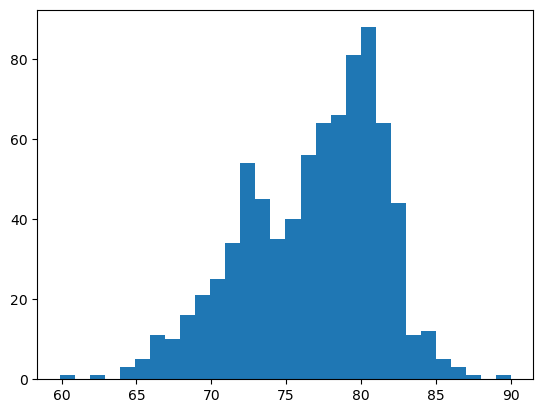

In [36]:
#create historgram of life expectancy on df_imputed
plt.hist(df_imputed['Life Expectancy'], bins=30)
plt.show()

In [37]:
#pd merge model[neighboorhood] and [area] with df_imputed, join on TRACT
model=pd.merge(model[['Tract','neighborhood','area']],df_imputed, on='Tract', how='inner')
model.head()


,Tract,neighborhood,area,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,NAME10
0,271400.0,EAST GARFIELD PARK,West Side,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,58.8,13.8,30.2,54.2,15.1,0.5,31.0,8.3,0.5,7.8,11.2,41.2,1185.0,51.9,48.1,2714.0,68.600000,3.622800,2714.0
1,280100.0,NEAR WEST SIDE,West Side,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,58.1,9.5,1.3,25.4,3.5,43.6,6.1,7.3,14.1,6811.0,49.3,50.7,2801.0,74.068631,2.721147,2801.0
2,310300.0,LOWER WEST SIDE,West Side,1126.0,11.1,66.0,14.2,14.4,7.9,15.6,26.3,11.7,49.5,23.8,31.4,21.7,37.6,30.5,10.2,51.7,5.7,5.5,10.8,3.6,22.6,1673.0,59.0,41.0,3103.0,79.100000,3.222500,3103.0
3,200200.0,HERMOSA,Northwest Side,2440.0,7.4,57.7,26.9,22.8,14.5,34.6,6.8,2.6,32.8,49.0,21.9,24.7,32.6,30.3,12.3,66.0,8.9,4.1,1.6,2.0,17.4,4815.0,50.8,49.2,2002.0,78.500000,1.940100,2002.0
4,221400.0,LOGAN SQUARE,North Side,2048.0,2.9,76.9,12.7,4.5,8.8,22.6,29.6,14.7,63.7,14.8,24.2,22.0,60.7,15.3,2.0,38.8,5.7,0.3,4.4,9.6,41.2,3034.0,58.3,41.7,2214.0,80.900000,3.074800,2214.0


## Creating Catagorical Variables

### Unemployment Category

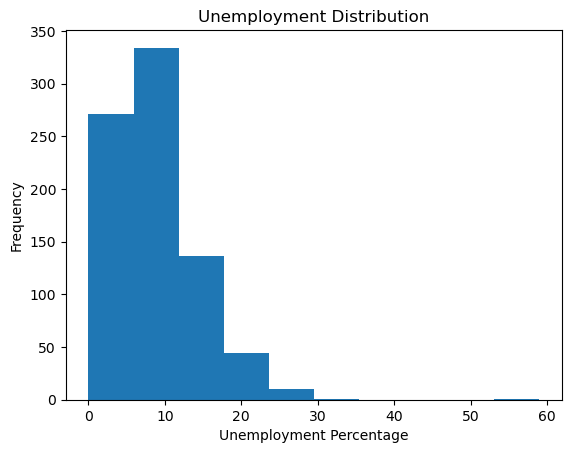

In [38]:
#histogram of unemployment
plt.hist(model['Unemployed'], bins=10)
plt.xlabel('Unemployment Percentage')
plt.ylabel('Frequency')
plt.title('Unemployment Distribution')
plt.show()

In [39]:

def categorize_unemployment_percentage(percentage):
    if percentage <= 5:
        return 'less than 5%'
    elif 5 < percentage <= 10:
        return '5-10%'
    elif 10 < percentage <= 15:
        return '10-15%'
    elif 15 < percentage <= 20:
        return '15-20%'
    elif 20 < percentage <= 25:
        return '20-25%'
    else:
        return '25 or more'


model['Unemployed_cat'] = model['Unemployed'].apply(categorize_unemployment_percentage)

In [40]:
print(model['Unemployed_cat'].describe())
model.head()

count       797
unique        6
top       5-10%
freq        322
Name: Unemployed_cat, dtype: object


,Tract,neighborhood,area,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,NAME10,Unemployed_cat
0,271400.0,EAST GARFIELD PARK,West Side,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,58.8,13.8,30.2,54.2,15.1,0.5,31.0,8.3,0.5,7.8,11.2,41.2,1185.0,51.9,48.1,2714.0,68.600000,3.622800,2714.0,5-10%
1,280100.0,NEAR WEST SIDE,West Side,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,58.1,9.5,1.3,25.4,3.5,43.6,6.1,7.3,14.1,6811.0,49.3,50.7,2801.0,74.068631,2.721147,2801.0,less than 5%
2,310300.0,LOWER WEST SIDE,West Side,1126.0,11.1,66.0,14.2,14.4,7.9,15.6,26.3,11.7,49.5,23.8,31.4,21.7,37.6,30.5,10.2,51.7,5.7,5.5,10.8,3.6,22.6,1673.0,59.0,41.0,3103.0,79.100000,3.222500,3103.0,10-15%
3,200200.0,HERMOSA,Northwest Side,2440.0,7.4,57.7,26.9,22.8,14.5,34.6,6.8,2.6,32.8,49.0,21.9,24.7,32.6,30.3,12.3,66.0,8.9,4.1,1.6,2.0,17.4,4815.0,50.8,49.2,2002.0,78.500000,1.940100,2002.0,5-10%
4,221400.0,LOGAN SQUARE,North Side,2048.0,2.9,76.9,12.7,4.5,8.8,22.6,29.6,14.7,63.7,14.8,24.2,22.0,60.7,15.3,2.0,38.8,5.7,0.3,4.4,9.6,41.2,3034.0,58.3,41.7,2214.0,80.900000,3.074800,2214.0,less than 5%


In the following catagories, we assigned a category to the variable that had the highest percentage in the tract

### Sex Category

In [41]:

def categorize_sex_percentage(percentage):
    if percentage < 50:
        return 'More Men'
    else:
        return 'More Women'

model['sex_cat'] = model['Female'].apply(categorize_sex_percentage)


In [42]:
model['sex_cat'].describe()


count            797
unique             2
top       More Women
freq             528
Name: sex_cat, dtype: object

### Number of Vehicles

In [43]:

def get_max_category(row):
    vehicle_categories = ['No Vehicles', 'One Vehicle', 'Two Vehicles', 'Three+ Vehicles']
    max_category = max(vehicle_categories, key=lambda x: row[x])
    return max_category

model['vehicle_cat'] = model.apply(get_max_category, axis=1)

print(model[['No Vehicles', 'One Vehicle', 'Two Vehicles', 'Three+ Vehicles', 'vehicle_cat']])


     No Vehicles  One Vehicle  Two Vehicles  Three+ Vehicles  vehicle_cat
0           30.2         54.2          15.1              0.5  One Vehicle
1           31.0         58.1           9.5              1.3  One Vehicle
2           21.7         37.6          30.5             10.2  One Vehicle
3           24.7         32.6          30.3             12.3  One Vehicle
4           22.0         60.7          15.3              2.0  One Vehicle
..           ...          ...           ...              ...          ...
792         21.9         57.6          16.3              4.2  One Vehicle
793         34.7         53.3          11.4              0.5  One Vehicle
794         16.8         50.8          29.8              2.6  One Vehicle
795         20.5         58.7          17.2              3.6  One Vehicle
796          8.4         43.1          33.7             14.8  One Vehicle

[797 rows x 5 columns]


In [44]:
model['vehicle_cat'].describe()

count             797
unique              4
top       One Vehicle
freq              576
Name: vehicle_cat, dtype: object

## Mode of transportation category

In [45]:

def get_max_transport_mode(row):
    transport_modes = ['Drive Alone', 'Carpooled', 'Walked', 'Other means', 'WFH', 'Public Transit']
    max_mode = max(transport_modes, key=lambda x: row[x])
    return max_mode


model['transport_cat'] = model.apply(get_max_transport_mode, axis=1)

print(model[['Drive Alone', 'Carpooled', 'Walked', 'Other means', 'WFH', 'Public Transit', 'transport_cat']])


     Drive Alone  Carpooled  Walked  Other means   WFH  Public Transit  \
0           31.0        8.3     0.5          7.8  11.2            41.2   
1           25.4        3.5    43.6          6.1   7.3            14.1   
2           51.7        5.7     5.5         10.8   3.6            22.6   
3           66.0        8.9     4.1          1.6   2.0            17.4   
4           38.8        5.7     0.3          4.4   9.6            41.2   
..           ...        ...     ...          ...   ...             ...   
792         31.7        2.6    10.2          2.3   3.6            49.5   
793         33.3        5.1     8.4          4.1   3.6            45.5   
794         60.9        8.0     5.0          3.0   2.1            21.1   
795         38.9        7.5     4.2          5.9   8.2            35.4   
796         64.8        8.9     3.0          1.3   3.8            18.3   

      transport_cat  
0    Public Transit  
1            Walked  
2       Drive Alone  
3       Drive Alone  
4

In [46]:
model['transport_cat'].describe()


count             797
unique              4
top       Drive Alone
freq              620
Name: transport_cat, dtype: object

## Education Category

In [47]:
def get_max_education_level(row):
    education_levels = ['No HS','Some HS','HS Graduates', 'Bachelors Degree', 'Grad/Prof Degree']
    max_level = max(education_levels, key=lambda x: row[x])
    return max_level

model['education_cat'] = model.apply(get_max_education_level, axis=1)

print(model[['No HS','Some HS','HS Graduates', 'Bachelors Degree', 'Grad/Prof Degree', 'education_cat']])


     No HS  Some HS  HS Graduates  Bachelors Degree  Grad/Prof Degree  \
0      3.0     22.9          26.0              11.0               3.0   
1      0.0      0.0           3.8              49.4              39.9   
2     14.4      7.9          15.6              26.3              11.7   
3     22.8     14.5          34.6               6.8               2.6   
4      4.5      8.8          22.6              29.6              14.7   
..     ...      ...           ...               ...               ...   
792    0.0      0.0           3.4              54.4              35.6   
793    8.5      4.6          18.7              27.2              18.6   
794    8.2      5.7          19.5              25.9              16.6   
795    2.3      3.3           8.7              36.6              31.5   
796    7.1      4.7          15.1              27.4              23.9   

        education_cat  
0        HS Graduates  
1    Bachelors Degree  
2    Bachelors Degree  
3        HS Graduates  
4  

In [48]:
model['education_cat'].describe()

count              797
unique               5
top       HS Graduates
freq               458
Name: education_cat, dtype: object

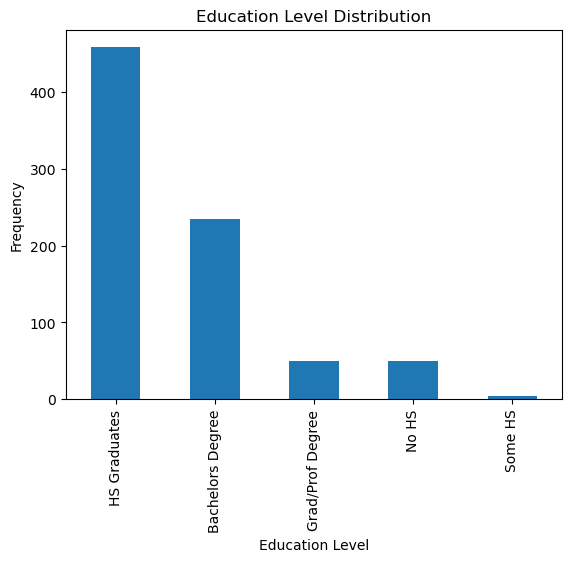

In [49]:
#make a bar chart for education level
education_counts = model['education_cat'].value_counts()
education_counts.plot(kind='bar')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.title('Education Level Distribution')
plt.show()

## Health Insurance Category

In [50]:

def get_max_health_insurance(row):
    health_insurance_categories = ['Private Health Ins', 'Public Health Ins', 'No Health Ins']
    max_category = max(health_insurance_categories, key=lambda x: row[x])
    return max_category

# Apply the function to each row and create a new column
model['health_ins_cat'] = model.apply(get_max_health_insurance, axis=1)

print(model[['Private Health Ins', 'Public Health Ins', 'No Health Ins', 'health_ins_cat']])


     Private Health Ins  Public Health Ins  No Health Ins      health_ins_cat
0                  30.1               58.8           13.8   Public Health Ins
1                  94.5                4.7            3.6  Private Health Ins
2                  49.5               23.8           31.4  Private Health Ins
3                  32.8               49.0           21.9   Public Health Ins
4                  63.7               14.8           24.2  Private Health Ins
..                  ...                ...            ...                 ...
792                93.1                3.8            5.1  Private Health Ins
793                63.3               19.1           22.3  Private Health Ins
794                51.7               36.9           18.0  Private Health Ins
795                76.6               16.1           13.2  Private Health Ins
796                76.5               21.7           10.1  Private Health Ins

[797 rows x 4 columns]


In [51]:
model.head()

,Tract,neighborhood,area,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,NAME10,Unemployed_cat,sex_cat,vehicle_cat,transport_cat,education_cat,health_ins_cat
0,271400.0,EAST GARFIELD PARK,West Side,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,58.8,13.8,30.2,54.2,15.1,0.5,31.0,8.3,0.5,7.8,11.2,41.2,1185.0,51.9,48.1,2714.0,68.600000,3.622800,2714.0,5-10%,More Men,One Vehicle,Public Transit,HS Graduates,Public Health Ins
1,280100.0,NEAR WEST SIDE,West Side,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,58.1,9.5,1.3,25.4,3.5,43.6,6.1,7.3,14.1,6811.0,49.3,50.7,2801.0,74.068631,2.721147,2801.0,less than 5%,More Women,One Vehicle,Walked,Bachelors Degree,Private Health Ins
2,310300.0,LOWER WEST SIDE,West Side,1126.0,11.1,66.0,14.2,14.4,7.9,15.6,26.3,11.7,49.5,23.8,31.4,21.7,37.6,30.5,10.2,51.7,5.7,5.5,10.8,3.6,22.6,1673.0,59.0,41.0,3103.0,79.100000,3.222500,3103.0,10-15%,More Men,One Vehicle,Drive Alone,Bachelors Degree,Private Health Ins
3,200200.0,HERMOSA,Northwest Side,2440.0,7.4,57.7,26.9,22.8,14.5,34.6,6.8,2.6,32.8,49.0,21.9,24.7,32.6,30.3,12.3,66.0,8.9,4.1,1.6,2.0,17.4,4815.0,50.8,49.2,2002.0,78.500000,1.940100,2002.0,5-10%,More Men,One Vehicle,Drive Alone,HS Graduates,Public Health Ins
4,221400.0,LOGAN SQUARE,North Side,2048.0,2.9,76.9,12.7,4.5,8.8,22.6,29.6,14.7,63.7,14.8,24.2,22.0,60.7,15.3,2.0,38.8,5.7,0.3,4.4,9.6,41.2,3034.0,58.3,41.7,2214.0,80.900000,3.074800,2214.0,less than 5%,More Men,One Vehicle,Public Transit,Bachelors Degree,Private Health Ins


## Life Expectancy Category
1 = Observed Life Expectancy is greater than the average 

0 = Observed life Expectancy is lower than the average 

In [52]:
#average life expectancy
avg_life_expectancy = model['Life Expectancy'].mean()
print(avg_life_expectancy)

76.76306956141569


In [53]:
average_life_expectancy = avg_life_expectancy

def above_average_life_expectancy(row):
    if row['Life Expectancy'] > average_life_expectancy:
        return '1' #1 is Yes LE is greater than the average LE observed
    else:
        return '0' #0 is NO LE is lower than the average LE observed


model['Life Expectancy_abvavg'] = model.apply(above_average_life_expectancy, axis=1)


print(model.head())


      Tract        neighborhood            area  Labor Force  Unemployed  \
0  271400.0  EAST GARFIELD PARK       West Side        456.0         8.5   
1  280100.0      NEAR WEST SIDE       West Side       5892.0         2.7   
2  310300.0     LOWER WEST SIDE       West Side       1126.0        11.1   
3  200200.0             HERMOSA  Northwest Side       2440.0         7.4   
4  221400.0        LOGAN SQUARE      North Side       2048.0         2.9   

   Employed  Family Poverty  No HS  Some HS  HS Graduates  Bachelors Degree  \
0      39.9            43.3    3.0     22.9          26.0              11.0   
1      88.6             0.0    0.0      0.0           3.8              49.4   
2      66.0            14.2   14.4      7.9          15.6              26.3   
3      57.7            26.9   22.8     14.5          34.6               6.8   
4      76.9            12.7    4.5      8.8          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Healt

## Life Expectancy Difference
Difference in observed and average Life Expectancy 

In [54]:

model['Life_Expectancy_Difference'] = model['Life Expectancy'] - average_life_expectancy

print(model.head())


      Tract        neighborhood            area  Labor Force  Unemployed  \
0  271400.0  EAST GARFIELD PARK       West Side        456.0         8.5   
1  280100.0      NEAR WEST SIDE       West Side       5892.0         2.7   
2  310300.0     LOWER WEST SIDE       West Side       1126.0        11.1   
3  200200.0             HERMOSA  Northwest Side       2440.0         7.4   
4  221400.0        LOGAN SQUARE      North Side       2048.0         2.9   

   Employed  Family Poverty  No HS  Some HS  HS Graduates  Bachelors Degree  \
0      39.9            43.3    3.0     22.9          26.0              11.0   
1      88.6             0.0    0.0      0.0           3.8              49.4   
2      66.0            14.2   14.4      7.9          15.6              26.3   
3      57.7            26.9   22.8     14.5          34.6               6.8   
4      76.9            12.7    4.5      8.8          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Healt

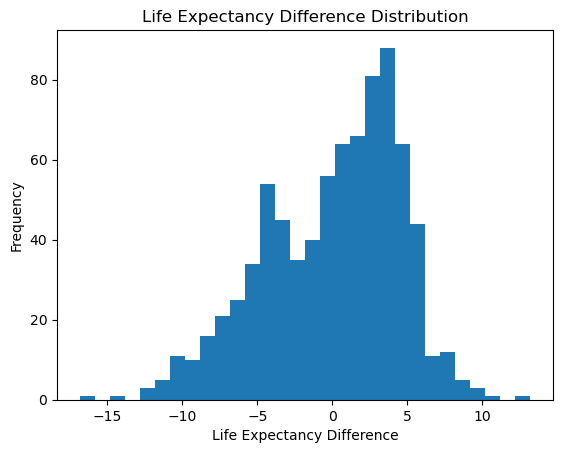

In [55]:
#histogram of life expectancy difference
plt.hist(model['Life_Expectancy_Difference'], bins=30)
plt.xlabel('Life Expectancy Difference')
plt.ylabel('Frequency')
plt.title('Life Expectancy Difference Distribution')
plt.show()

## One-Hot Encoding of Categoricl Variables 

In [56]:
categorical_columns = ['Unemployed_cat', 'sex_cat', 'vehicle_cat', 'transport_cat', 'education_cat', 'health_ins_cat', 'area']

encoded_columns = pd.get_dummies(model[categorical_columns], prefix=categorical_columns, prefix_sep='_')

encoded_columns = encoded_columns.apply(lambda x: x.astype(int))

model_1 = pd.concat([model, encoded_columns], axis=1)

model_1.drop(columns=categorical_columns, inplace=True)

print(model_1.head())


      Tract        neighborhood  Labor Force  Unemployed  Employed  \
0  271400.0  EAST GARFIELD PARK        456.0         8.5      39.9   
1  280100.0      NEAR WEST SIDE       5892.0         2.7      88.6   
2  310300.0     LOWER WEST SIDE       1126.0        11.1      66.0   
3  200200.0             HERMOSA       2440.0         7.4      57.7   
4  221400.0        LOGAN SQUARE       2048.0         2.9      76.9   

   Family Poverty  No HS  Some HS  HS Graduates  Bachelors Degree  \
0            43.3    3.0     22.9          26.0              11.0   
1             0.0    0.0      0.0           3.8              49.4   
2            14.2   14.4      7.9          15.6              26.3   
3            26.9   22.8     14.5          34.6               6.8   
4            12.7    4.5      8.8          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Health Ins  \
0               3.0                30.1               58.8           13.8   
1         

In [57]:
model_1.head()

,Tract,neighborhood,Labor Force,Unemployed,Employed,Family Poverty,No HS,Some HS,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,One Vehicle,Two Vehicles,Three+ Vehicles,Drive Alone,Carpooled,Walked,Other means,WFH,Public Transit,Total Population,Male,Female,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,NAME10,Life Expectancy_abvavg,Life_Expectancy_Difference,Unemployed_cat_10-15%,Unemployed_cat_15-20%,Unemployed_cat_20-25%,Unemployed_cat_25 or more,Unemployed_cat_5-10%,Unemployed_cat_less than 5%,sex_cat_More Men,sex_cat_More Women,vehicle_cat_No Vehicles,vehicle_cat_One Vehicle,vehicle_cat_Three+ Vehicles,vehicle_cat_Two Vehicles,transport_cat_Carpooled,transport_cat_Drive Alone,transport_cat_Public Transit,transport_cat_Walked,education_cat_Bachelors Degree,education_cat_Grad/Prof Degree,education_cat_HS Graduates,education_cat_No HS,education_cat_Some HS,health_ins_cat_No Health Ins,health_ins_cat_Private Health Ins,health_ins_cat_Public Health Ins,area_Central,area_Far North Side,area_Far South Side,area_Far Southwest Side,area_North Side,area_Northwest Side,area_South Side,area_Southwest Side,area_West Side
0,271400.0,EAST GARFIELD PARK,456.0,8.5,39.9,43.3,3.0,22.9,26.0,11.0,3.0,30.1,58.8,13.8,30.2,54.2,15.1,0.5,31.0,8.3,0.5,7.8,11.2,41.2,1185.0,51.9,48.1,2714.0,68.600000,3.622800,2714.0,0,-8.163070,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,280100.0,NEAR WEST SIDE,5892.0,2.7,88.6,0.0,0.0,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,58.1,9.5,1.3,25.4,3.5,43.6,6.1,7.3,14.1,6811.0,49.3,50.7,2801.0,74.068631,2.721147,2801.0,0,-2.694439,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,310300.0,LOWER WEST SIDE,1126.0,11.1,66.0,14.2,14.4,7.9,15.6,26.3,11.7,49.5,23.8,31.4,21.7,37.6,30.5,10.2,51.7,5.7,5.5,10.8,3.6,22.6,1673.0,59.0,41.0,3103.0,79.100000,3.222500,3103.0,1,2.336930,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,200200.0,HERMOSA,2440.0,7.4,57.7,26.9,22.8,14.5,34.6,6.8,2.6,32.8,49.0,21.9,24.7,32.6,30.3,12.3,66.0,8.9,4.1,1.6,2.0,17.4,4815.0,50.8,49.2,2002.0,78.500000,1.940100,2002.0,1,1.736930,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,221400.0,LOGAN SQUARE,2048.0,2.9,76.9,12.7,4.5,8.8,22.6,29.6,14.7,63.7,14.8,24.2,22.0,60.7,15.3,2.0,38.8,5.7,0.3,4.4,9.6,41.2,3034.0,58.3,41.7,2214.0,80.900000,3.074800,2214.0,1,4.136930,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## Export Final Model

In [58]:
model=model_1
#export model to csv
model.to_csv('final_model.csv', index=False)